# Disease Prediction Model & Comprehensive Data Analysis

This notebook provides a robust pipeline for disease prediction based on symptoms.

**Steps covered:**
1.  **Data Loading & Cleaning**: Handling missing values and ensuring data quality.
2.  **Exploratory Data Analysis (EDA)**: Visualizing disease distribution and symptom frequency.
3.  **Feature Engineering**: Transforming symptom lists into a binary format suitable for machine learning.
4.  **Model Training**: Using Logistic Regression with Cross-Validation.
5.  **Evaluation**: Confusion Matrix and Classification Report.
6.  **Inference**: Testing the model with example inputs.

---

## 1. Import Libraries and Load Data

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import warnings
import pickle

warnings.filterwarnings('ignore')

# Set plot style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [32]:
# Load the dataset
try:
    df = pd.read_csv('./data/dataset.csv')
    print("Dataset loaded successfully.")
    print("Shape:", df.shape)
except FileNotFoundError:
    print("Error: 'dataset.csv' not found. Please ensure the file is in the './data/' directory.")

Dataset loaded successfully.
Shape: (4920, 18)


In [33]:
df.head()

,Disease,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5,Symptom_6,Symptom_7,Symptom_8,Symptom_9,Symptom_10,Symptom_11,Symptom_12,Symptom_13,Symptom_14,Symptom_15,Symptom_16,Symptom_17
0,Fungal infection,itching,skin_rash,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Fungal infection,skin_rash,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Fungal infection,itching,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Fungal infection,itching,skin_rash,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Fungal infection,itching,skin_rash,nodal_skin_eruptions,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 2. Data Cleaning & Preprocessing

In [34]:
# Check for missing values
print("Missing values per column:\n", df.isnull().sum())

Missing values per column:
 Disease          0
Symptom_1        0
Symptom_2        0
Symptom_3        0
Symptom_4      348
Symptom_5     1206
Symptom_6     1986
Symptom_7     2652
Symptom_8     2976
Symptom_9     3228
Symptom_10    3408
Symptom_11    3726
Symptom_12    4176
Symptom_13    4416
Symptom_14    4614
Symptom_15    4680
Symptom_16    4728
Symptom_17    4848
dtype: int64


In [35]:
# The dataset has symptoms in columns Symptom_1 to Symptom_17.
# Missing values just mean the patient didn't have that many symptoms.
# We will fill NaNs with 0 or a placeholder string to handle them easier later.

df = df.fillna(0)
print("Missing values handled.")

Missing values handled.


## 3. Exploratory Data Analysis (EDA)

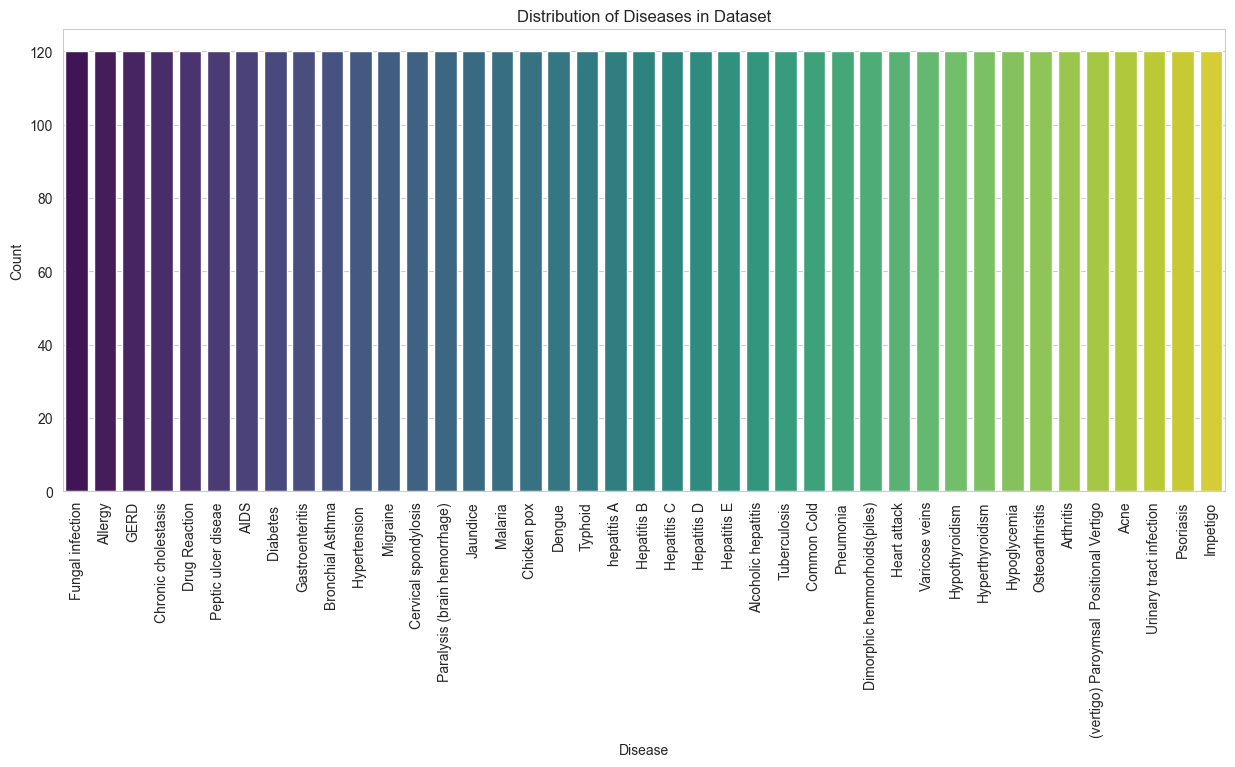

In [36]:
# 1. Distribution of Target Variable (Disease)
plt.figure(figsize=(15, 6))
disease_counts = df['Disease'].value_counts()
sns.barplot(x=disease_counts.index, y=disease_counts.values, palette='viridis')
plt.title('Distribution of Diseases in Dataset')
plt.xlabel('Disease')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

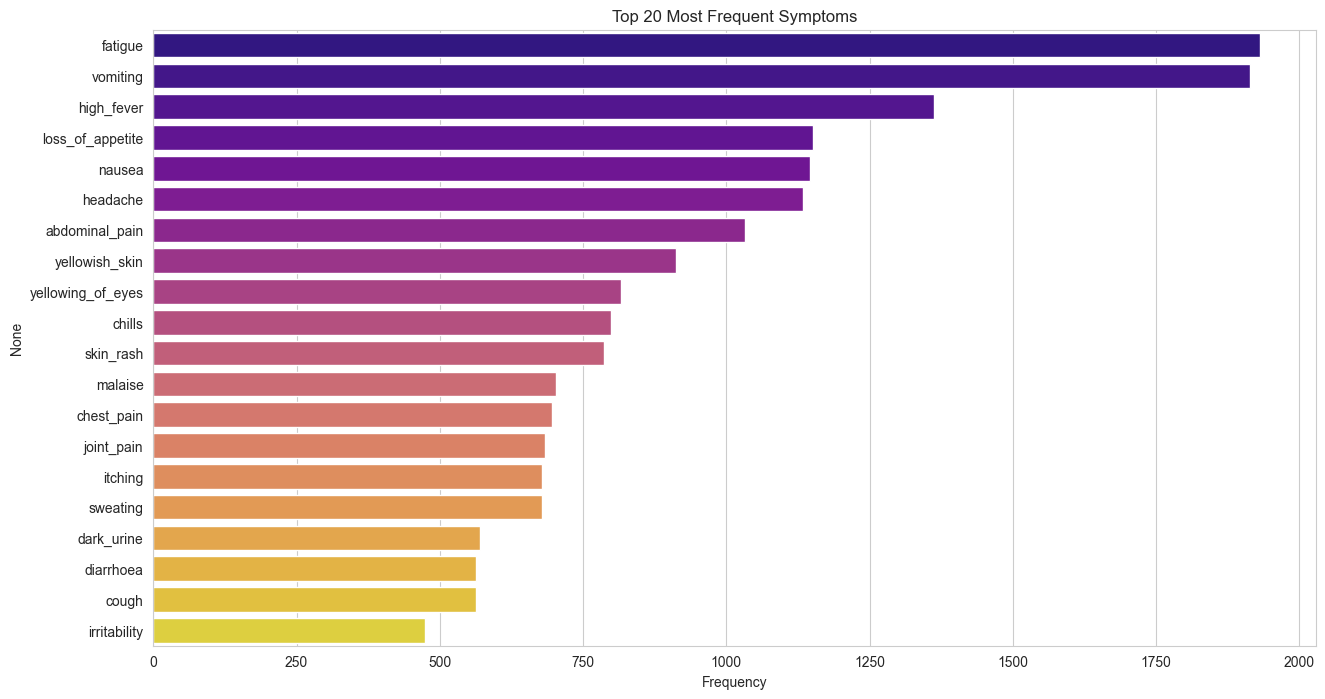

In [ ]:
# Most Frequent Symptoms
#  flatten all symptom columns to count total occurrences of each symptom

symptom_columns = [col for col in df.columns if 'Symptom' in col]
all_symptoms = []

for col in symptom_columns:
    all_symptoms.extend(df[col].astype(str).values)

# Filter out '0' and extra spaces, and lowercase
all_symptoms = [str(s).strip().lower() for s in all_symptoms if s != 0 and s != '0']

symptom_counts = pd.Series(all_symptoms).value_counts().head(20)

plt.figure(figsize=(15, 8))
sns.barplot(y=symptom_counts.index, x=symptom_counts.values, palette='plasma')
plt.title('Top 20 Most Frequent Symptoms')
plt.xlabel('Frequency')
plt.show()

## 4. Feature Engineering
Convert the dataset into a format where columns are unique symptoms and rows indicate presence (1) or absence (0).

In [47]:
# Get all unique symptoms from the dataset
unique_symptoms = sorted(list(set(all_symptoms)))
print(f"Total Unique Symptoms: {len(unique_symptoms)}")

# Create an empty DataFrame for the new features
new_df = pd.DataFrame(columns=unique_symptoms)

# Function to encode symptoms for each row
def encode_symptoms(row):
    # Create a zero-filled series with unique symptoms as index
    symptom_series = pd.Series(0, index=unique_symptoms)
    
    # For each symptom in the row, set the corresponding index to 1
    for col in symptom_columns:
        symptom = row[col]
        if symptom != 0 and symptom != '0':
            symptom_name = str(symptom).strip().lower()
            if symptom_name in unique_symptoms:
                symptom_series[symptom_name] = 1
    return symptom_series



X_encoded = df.apply(encode_symptoms, axis=1)
df_final = pd.concat([df['Disease'], X_encoded], axis=1)

print("Encoding complete.")
df_final.head()

Total Unique Symptoms: 131
Encoding complete.


,Disease,abdominal_pain,abnormal_menstruation,acidity,acute_liver_failure,altered_sensorium,anxiety,back_pain,belly_pain,blackheads,...,vomiting,watering_from_eyes,weakness_in_limbs,weakness_of_one_body_side,weight_gain,weight_loss,yellow_crust_ooze,yellow_urine,yellowing_of_eyes,yellowish_skin
0,Fungal infection,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Fungal infection,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Fungal infection,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Fungal infection,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Fungal infection,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 5. Model Training


In [48]:
X = df_final.drop('Disease', axis=1)
y = df_final['Disease']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training Set: {X_train.shape}")
print(f"Test Set: {X_test.shape}")

Training Set: (3936, 131)
Test Set: (984, 131)


In [49]:
# Initialize and train model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Accuracy Score
acc = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {acc * 100:.2f}%")

Model Accuracy: 100.00%


In [ ]:
# Cross-Validation
# If this is also 100%, it means the dataset is highly separable / synthetic.
cv_scores = cross_val_score(model, X, y, cv=5)
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean CV Score: {np.mean(cv_scores) * 100:.2f}%")

Cross-Validation Scores: [1. 1. 1. 1. 1.]
Mean CV Score: 100.00%


## 6. Evaluation

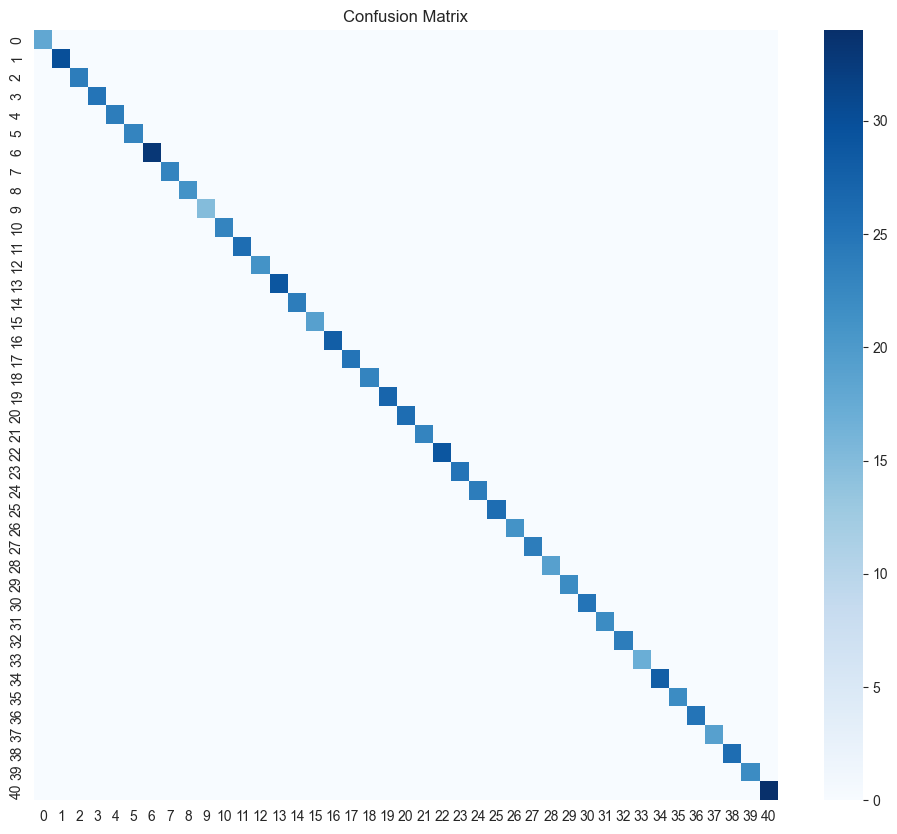

In [51]:
# Confusion Matrix
plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=False, cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [43]:
# Classification Report
print(classification_report(y_test, y_pred))

                                         precision    recall  f1-score   support

(vertigo) Paroymsal  Positional Vertigo       1.00      1.00      1.00        18
                                   AIDS       1.00      1.00      1.00        30
                                   Acne       1.00      1.00      1.00        24
                    Alcoholic hepatitis       1.00      1.00      1.00        25
                                Allergy       1.00      1.00      1.00        24
                              Arthritis       1.00      1.00      1.00        23
                       Bronchial Asthma       1.00      1.00      1.00        33
                   Cervical spondylosis       1.00      1.00      1.00        23
                            Chicken pox       1.00      1.00      1.00        21
                    Chronic cholestasis       1.00      1.00      1.00        15
                            Common Cold       1.00      1.00      1.00        23
                           

## 7. Saving the Model & Inference Function

In [44]:
# Save the model and the unique symptoms list
with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)

# Important: We must also save the column order (unique_symptoms) to ensure consistent input during inference
with open('features.pkl', 'wb') as f:
    pickle.dump(unique_symptoms, f)

print("Model and features saved successfully.")

Model and features saved successfully.


In [45]:
def predict_disease(symptom_list):
    # Load model and features
    try:
        with open('model.pkl', 'rb') as f:
            loaded_model = pickle.load(f)
        with open('features.pkl', 'rb') as f:
            feature_names = pickle.load(f)
    except FileNotFoundError:
        return "Error: Model files not found."

    # Create input vector
    input_vector = np.zeros(len(feature_names))
    
    for symptom in symptom_list:
        symptom = str(symptom).strip().lower()
        if symptom in feature_names:
            idx = feature_names.index(symptom)
            input_vector[idx] = 1
        else:
            print(f"Warning: Symptom '{symptom}' not recognized by model.")
            
    # Predict
    prediction = loaded_model.predict([input_vector])
    return prediction[0]

# Test Inference
test_symptoms = ['itching', 'skin_rash', 'nodal_skin_eruptions']
result = predict_disease(test_symptoms)
print(f"Symptoms: {test_symptoms} -> Predicted Disease: {result}")

Symptoms: ['itching', 'skin_rash', 'nodal_skin_eruptions'] -> Predicted Disease: Fungal infection
